In [1]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import os
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u

homedir = os.getenv("HOME")

In [2]:
nv = Table.read(homedir+'/research/NED-LVS/NEDLVS_20210922_v2.fits')

# JM files
nvgeom = Table.read(homedir+'/research/NED-LVS/NEDgeometry-NEDLVS_20210922_v2.fits')
nvbyname = Table.read(homedir+'/research/NED-LVS/NEDbyname-NEDLVS_20210922_v2.fits') # row gives index for original file

nv = nv[nvbyname['ROW']]


In [3]:
print(nv.colnames)

['objname', 'ra', 'dec', 'objtype', 'z', 'z_unc', 'z_tech', 'z_qual', 'z_qual_flag', 'z_refcode', 'ziDist', 'ziDist_unc', 'ziDist_method', 'ziDist_indicator', 'ziDist_refcode', 'DistMpc', 'DistMpc_unc', 'DistMpc_method', 'ebv', 'A_FUV_MWext', 'A_NUV_MWext', 'A_J_MWext', 'A_H_MWext', 'A_Ks_MWext', 'A_W1_MWext', 'A_W2_MWext', 'A_W3_MWext', 'A_W4_MWext', 'm_FUV', 'm_FUV_unc', 'm_NUV', 'm_NUV_unc', 'Lum_FUV', 'Lum_FUV_unc', 'Lum_NUV', 'Lum_NUV_unc', 'GALEXphot', 'm_J', 'm_J_unc', 'm_H', 'm_H_unc', 'm_Ks', 'm_Ks_unc', 'Lum_J', 'Lum_J_unc', 'Lum_H', 'Lum_H_unc', 'Lum_Ks', 'Lum_Ks_unc', 'tMASSphot', 'm_W1', 'm_W1_unc', 'm_W2', 'm_W2_unc', 'm_W3', 'm_W3_unc', 'm_W4', 'm_W4_unc', 'Lum_W1', 'Lum_W1_unc', 'Lum_W2', 'Lum_W2_unc', 'Lum_W3', 'Lum_W3_unc', 'Lum_W4', 'Lum_W4_unc', 'WISEphot', 'SFR_W4', 'SFR_W4_unc', 'SFR_hybrid', 'SFR_hybrid_unc', 'ET_flag', 'Mstar', 'Mstar_unc', 'MLratio']


In [4]:

manga = Table.read(homedir+'/research/MaNGA/dapall-v3_1_1-3.1.0.fits',1)
print(manga)

PLATE IFUDESIGN   PLATEIFU  ...    SFR_1RE       SFR_TOT   
----- --------- ----------- ... ------------- -------------
 7443      1902   7443-1902 ... 0.00012191864 0.00021406014
 7443     12704  7443-12704 ...    0.09200222    0.10437316
 7443      1901   7443-1901 ...   0.036917206   0.046947174
 7443      3702   7443-3702 ...   0.021709457   0.039944503
 7443      3704   7443-3704 ...   0.018293345   0.038960442
 7443     12701  7443-12701 ...  0.0018383963  0.0027225188
 7443      3701   7443-3701 ...   0.019483615   0.040221334
 7443     12705  7443-12705 ...    0.22162208    0.56159633
 7443      6104   7443-6104 ...   0.077241436   0.124319896
 7443      6102   7443-6102 ...    0.44643736    0.63374007
  ...       ...         ... ...           ...           ...
12772      1902  12772-1902 ... 0.00012330317  0.0004104719
12772      3702  12772-3702 ...  0.0015077139   0.013312489
12772     12702 12772-12702 ...   0.089836806    0.11806552
12772      6103  12772-6103 ...    0.149

In [5]:
# don't use any galaxies outside this range
zflag = (nv['z'] > 0.002) & (nv['z'] < .025)
decflag = nv['dec'] > -20
massflag = np.log10(nv['Mstar']) > 7
allcut = zflag & decflag & massflag
nv = nv[allcut]
nvgeom = nvgeom[allcut]
nvbyname = nvbyname[allcut]


# other cuts
massflag = np.log10(nv['Mstar']) > 8
sizeflag = nvgeom['DIAM'] > 15/60 # requiring Diam to be greater than 30arcsec?
sSFRflag = np.log10(nv['SFR_hybrid']/nv['Mstar']) > -11.

# need to eliminate AGN
# could use wise color cut
agnflag = (nv['m_W1'] - nv['m_W2']) > .8

sampleflag = massflag & sizeflag & sSFRflag & ~agnflag
print(f"number of NED LVS meeting the primary sample cuts = {np.sum(sampleflag)}")



number of NED LVS meeting the primary sample cuts = 15165


In [6]:
# set up filters
filter_centers = [656.3 + 4*i for i in range(5) ]
filter_centers = np.array(filter_centers)

lambda_rest = 656.3
filter_width = 8. #nm
filter_min = filter_centers - 0.5*filter_width
filter_max = filter_centers + 0.5*filter_width

filter_zmin = (filter_min-lambda_rest)/lambda_rest

filter_zmax = (filter_max-lambda_rest)/lambda_rest

# from halphagui
# lmin={'4':6573., '8':6606.,'12':6650.,'16':6682.,'INT197':6520.5, 'INT227':6617}
# lmax={'4':6669., '8':6703.,'12':6747., '16':6779.,'INT197':6615.5, 'INT227':6697}

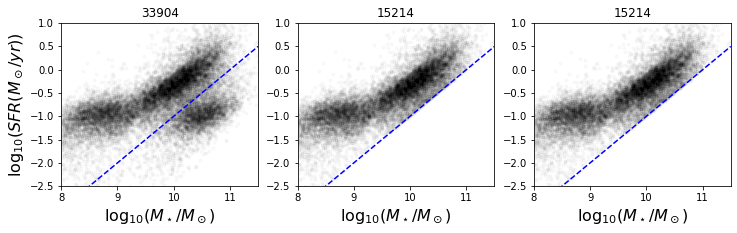

In [7]:
plt.figure(figsize=(12,3))

x = np.log10(nv['Mstar'])
y = np.log10(nv['SFR_hybrid'])

flags = [sizeflag & massflag,massflag & sizeflag & sSFRflag, massflag & sizeflag & sSFRflag]

for i,f in enumerate(flags):
    plt.subplot(1,3,i+1)

    plt.plot(x[f],y[f],'k.',alpha=.02)

    xline = np.linspace(8,11.5,100)
    plt.plot(xline,xline-11,'b--')
    plt.title(f"{np.sum(f)}")
    plt.xlabel("$\log_{10}(M_\star/M_\odot$)",fontsize=16)
    if i == 0:
        plt.ylabel("$\log_{10}(SFR (M_\odot/yr))$",fontsize=16)
    plt.axis([8,11.5,-2.5,1.])

In [8]:
# match catalog internally
# then sort by number of matches
# target those with multiple objects within FOV

# or just use topcat to find the groups?
print("sum of sampleflag = ",np.sum(sampleflag))
nedlvs2 = nv[sampleflag & ~sampleflag.mask]
print(len(nedlvs2))

sum of sampleflag =  15165
15165


In [9]:
outfile = homedir+'/research/NED-LVS/NEDLVS_20210922_v2_NSF_MRI.fits'
nedlvs2.write(outfile,format='fits',overwrite=True)
print(f"number of galaxies in NEDLVS2 = {len(nedlvs2)}")

number of galaxies in NEDLVS2 = 15165


In [10]:

# using colors from matplotlib default color cycle
mycolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

zmin = 0.0017
zmax = 0.025
sersicmin = 5.5
snrcut = 20

zmin = 0.002
zmax = 0.025
sersicmin = 5.5 # arcsec
snrcut = 20


# for UAT Telescope Survey
zmin = 0.002
zmax = 0.025
sersicmin = 3

mindiameter = 10
snrcut = 20

filter_wavec = 656.3+np.array([0,4,8,12,16]) # nm
filter_width = 8.0 # nm
filter_wave_min = filter_wavec - filter_width/2
filter_wave_max = filter_wavec + filter_width/2

# redshift - delta lambda/lamba = lobs/lem - 1
#
filter_zcenter = filter_wavec/656.3 - 1
filter_zmin = filter_wave_min/656.3 - 1
filter_zmax = filter_wave_max/656.3 - 1

def get_filter(z):
    """
    takes in the redshift

    returns the zmin, zmax of the filter that the galaxy falls in
    """

    # find filter with center closest to the redshift

    dz = np.abs(z - filter_zcenter)
    bestFilter = dz == np.min(dz)

    # check that gal is within filter limits (just a double check...)
    if (z > filter_zmin[bestFilter]) & (z < filter_zmax[bestFilter]):
            return filter_zmin[bestFilter][0],filter_zmax[bestFilter][0]
    return -99, -99

def find_groups_3d(ra,dec,z,maxoffset=0.4,verbose=False,testing=False):
    ngroups=0
    # keep track on which are group centers
    groupCenterFlag = np.zeros(len(ra),'bool')
    
    maxgroupsize = 100
    c = SkyCoord(ra=1*u.deg, dec=2*u.deg, radial_velocity=10*u.km/u.s)

    # search around 3d will give separation in 3d coords, but that is not what we want
    # so sticking with 2d search, and then will figure out how to include redshift
    cat1 = SkyCoord(ra*u.deg,dec*u.deg, frame='icrs')
    cat2 = SkyCoord(ra*u.deg,dec*u.deg, frame='icrs')
    
    # match and remove singles
    idxcat2all, idxcat1all, d2d, d3d = cat1.search_around_sky(cat2, maxoffset*u.deg)
    # remove self matches
    idxcat2 = idxcat2all[d2d > 0.]
    idxcat1 = idxcat1all[d2d > 0.]
    unique_values, counts = np.unique(idxcat2, return_counts=True)
    
    
    single_flag = np.ones(len(cat1),'bool')
    
    for id in unique_values[counts > 1]: 
        single_flag[id] = False
    singlemembs = np.arange(len(cat1))[single_flag]

    groupCenterFlag[single_flag] = np.ones(np.sum(single_flag),'bool')
    
    # track ra and dec of all pointings
    pointing_ra = []
    pointing_dec = []
 
    # get centers of single pointings
    #for index in singlemembs:
    #    pointing_ra.append(ra[index])
    #    pointing_dec.append(dec[index])
    singles_ra = []
    singles_dec = []
    for id in singlemembs:
        singles_ra.append(ra[id])
        singles_dec.append(dec[id])        
        
    #cat1 = cat1[~single_flag]
    #cat2 = cat2[~single_flag]

    #
    nsingles = np.sum(single_flag)
    if verbose:
        print("the number of single pointings = ",np.sum(single_flag))
    
        print("number of remaining galaxies in groups = ",np.sum(counts > 1))
        print("testing: ",len(cat1),np.sum(single_flag)+ np.sum(counts > 1))
    
    #print(len(idxcat1),len(idxcat1all))

    nmembgroup = []
    groupmembs = []
    surviveFlag = ~groupCenterFlag
    if verbose:
        print("number of galaxies surviving = ",np.sum(surviveFlag))
    remove_flag = np.zeros(len(cat1),'bool')
    nloop=0
    while maxgroupsize > 1:
        
        # find objects with match w/in max offset
        #print("matching catalogs...")
        if verbose:
            print()
            print("number of galaxies surviving = ",np.sum(surviveFlag))
            print(f"length of cat1[surviveFlag] = {len(cat1[surviveFlag])}")
        idxcat2all, idxcat1all, d2d, d3d = cat1[surviveFlag].search_around_sky(cat2[surviveFlag], maxoffset*u.deg)
        # remove self matches
        #idxcat2 = idxcat2all[d2d > 0.]
        #idxcat1 = idxcat1all[d2d > 0.]

        # translate this back to the indices of the uncut catalogs
        idxcat2 = np.arange(len(cat1))[surviveFlag][idxcat2all]
        idxcat1 = np.arange(len(cat1))[surviveFlag][idxcat1all]
        
        # find pointing with max number
        #print("finding unique ids ...")
        unique_values, counts = np.unique(idxcat2, return_counts=True)
        #print("number of unique groups = ",len(unique_values))
        maxgroupsize = np.max(counts)
        maxgroup_id = unique_values[counts == np.max(counts)]

        if verbose:
            print(f"maxgroup_id = {maxgroup_id}, max counts = {np.max(counts)}")
            
        if np.max(counts) == 1:
            #  * if max number is 1, then the remaining sources are single pointings
            ngroups += len(unique_values)

            
            return nsingles,ngroups,pointing_ra+singles_ra,pointing_dec+singles_dec,nmembgroup,groupmembs,singlemembs,groupCenterFlag
    
        # save as group 1
        nmembgroup.append(maxgroupsize)
        ngroups += 1
        # remove group 1 members from idxcat1 and idxcat 2
        
        if len(maxgroup_id) > 1:
            membs = idxcat1[idxcat2 == maxgroup_id[0]]
            centerID = maxgroup_id[0]
            groupCenterFlag[int(maxgroup_id[0])] = True
            pointing_ra.append(cat2.ra[int(maxgroup_id[0])].value)
            pointing_dec.append(cat2.dec[int(maxgroup_id[0])].value)
            
        else:
            membs = idxcat1[idxcat2 == maxgroup_id[0]]
            groupCenterFlag[int(maxgroup_id[0])] = True
            pointing_ra.append(cat2.ra[int(maxgroup_id[0])].value)
            pointing_dec.append(cat2.dec[int(maxgroup_id[0])].value)
            centerID = maxgroup_id[0]

        # get redshift range of the filter for this galaxy

        zmin,zmax = get_filter(z[centerID])
        zflag = (z[membs] > zmin) & (z[membs] < zmax)
        if verbose:
            print(f"centerID={centerID}")
            print(f"membs={membs}")
            print(f"zmin,zmax={zmin:.4f},{zmax:.4f},zobj={z[centerID]:.4f},{np.sum(zflag)},{z[membs]}")
        
        #print("number of membs = ",len(membs))
        #print("building remove_flag")
        #print("members = ",membs)
        #print(f"before eliminating, survive flag of membs = {surviveFlag[membs]}")        
        for m in membs:
            # remove members from idxcat1 and 2
            #groupmembs.append(cat1['NSAID'][m])
            #ragroup.append(cat1['RA'][m])
            #matchmemb_cat1 = cat1 == m
            if (z[m] > zmin) & (z[m] < zmax):
                remove_flag[m] = True
                surviveFlag[m] = False
                #matchmemb_cat2 = cat2 == m
                remove_flag[m] = True
        if testing:
            if ngroups > 10:
                break
        
    return nsingles,ngroups,pointing_ra+singles_ra,pointing_dec+singles_dec,nmembgroup,groupmembs,singlemembs,groupCenterFlag

In [11]:
ra = nedlvs2['ra']
dec = nedlvs2['dec']
z = nedlvs2['z']

nsingles,ngroups,pointing_ra,pointing_dec,nmembgroup,groupmembs,singlemembs,groupCenterFlag = find_groups_3d(ra,dec,z,maxoffset=0.6,verbose=False)


In [12]:
print(nsingles,ngroups,np.sum(nmembgroup))
print(np.sum(groupCenterFlag),len(groupCenterFlag))

7165 2841 8690
9066 15165


In [13]:
print(len(pointing_ra),len(groupCenterFlag),len(nmembgroup))
print(len(singlemembs))
print(len(groupmembs))

9066 15165 1901
7165
0


### Next Step

* Find number of galaxies within fov of all galaxies
* so far we just have the number of primary targets, so need to cross match the centers with the full nedlvs

In [14]:
# find all galaxies w/in the group centers
nvgood = nv
insampleflag = np.zeros(len(nvgood),'bool')
inprimarysampleflag = np.zeros(len(nedlvs2),'bool')
# loop over pointing ra and dec - groups are in the first part of the list
dxdeg = 0.62
Nmax_pointing = 4300 # number we can observe in 5 yrs
#for i in range(len(pointing_ra)):
for i in range(Nmax_pointing):
    
    # measure distance from nedlvs2 to center of pointing
    # keep galaxies w/in square of 0.6x0.6 from center
    
    ####################################################
    # wait!!!
    # need to add filter cut!!!
    ####################################################
    
    flag = (np.abs(nvgood['ra']-pointing_ra[i]) < dxdeg/2) & (np.abs(nvgood['dec']-pointing_dec[i]) < dxdeg/2)
    primaryflag = (np.abs(nedlvs2['ra']-pointing_ra[i]) < dxdeg/2) & (np.abs(nedlvs2['dec']-pointing_dec[i]) < dxdeg/2)
    # set insampleflag = True for these galaxies
    insampleflag[flag] = True
    inprimarysampleflag[primaryflag] = True

# quit when we hit ~4500 pointings
print(f"the number of galaxies in sample = {np.sum(insampleflag)}", len(insampleflag))
print(f"the number of primary galaxies in sample = {np.sum(inprimarysampleflag)}", len(inprimarysampleflag))

the number of galaxies in sample = 11993 48429
the number of primary galaxies in sample = 7001 15165


In [15]:
plt.figure(figsize=(12,3))

x = np.log10(nv['Mstar'])
y = np.log10(nv['SFR_hybrid'])

flags = [zflag&sizeflag & massflag&decflag,zflag&massflag & sizeflag & sSFRflag&decflag, insampleflag]

for i,f in enumerate(flags):
    plt.subplot(1,3,i+1)

    if i < 2:
        plt.plot(x[f],y[f],'k.',alpha=.02)
    else:
        s0 = f"Secondary ({np.sum(insampleflag) - np.sum(inprimarysampleflag)})"
        s1 = f"Primary ({np.sum(inprimarysampleflag)})"
        plt.plot(np.log10(nvgood['Mstar'][insampleflag]),np.log10(nvgood['SFR_hybrid'][insampleflag]),'k.',alpha=.02,label=s0)
        plt.plot(np.log10(nedlvs2['Mstar'][inprimarysampleflag]),np.log10(nedlvs2['SFR_hybrid'][inprimarysampleflag]),'b.',alpha=.03,label=s1)
        plt.legend()
    xline = np.linspace(8,11.5,100)
    plt.plot(xline,xline-11,'r--')
    plt.title(f"{np.sum(f)}")
    plt.xlabel("$\log_{10}(M_\star/M_\odot$)",fontsize=16)
    if i == 0:
        plt.ylabel("$\log_{10}(SFR (M_\odot/yr))$",fontsize=16)
    plt.axis([7.5,11.5,-2.5,1.])

ValueError: operands could not be broadcast together with shapes (1872340,) (48429,) 

<Figure size 864x216 with 0 Axes>

In [16]:
outfile = homedir+'/proposals/NSF-MRI-2024/nedlvs-fullsample.fits'
nvgood[insampleflag].write(outfile,format='fits',overwrite=True)

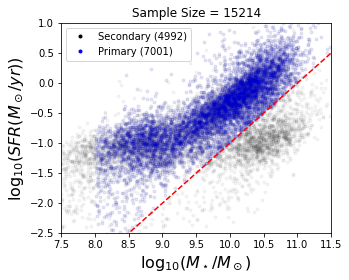

In [17]:
plt.figure(figsize=(5,4))

x = np.log10(nv['Mstar'])
y = np.log10(nv['SFR_hybrid'])

plt.subplots_adjust(left=.15,bottom=.15)
s0 = f"Secondary ({np.sum(insampleflag) - np.sum(inprimarysampleflag)})"
s1 = f"Primary ({np.sum(inprimarysampleflag)})"
plt.plot(np.log10(nvgood['Mstar'][insampleflag]),np.log10(nvgood['SFR_hybrid'][insampleflag]),'k.',alpha=.04,label=s0)
plt.plot(np.log10(nedlvs2['Mstar'][inprimarysampleflag]),np.log10(nedlvs2['SFR_hybrid'][inprimarysampleflag]),'b.',alpha=.05,label=s1)
xline = np.linspace(8,11.5,100)
plt.plot(xline,xline-11,'r--')
plt.title(f"Sample Size = {np.sum(f)}")
plt.xlabel("$\log_{10}(M_\star/M_\odot$)",fontsize=16)
plt.ylabel("$\log_{10}(SFR (M_\odot/yr))$",fontsize=16)
plt.axis([7.5,11.5,-2.5,1.])
leg = plt.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    #lh._legmarker.set_alpha(1)
plt.savefig(homedir+'/proposals/NSF-MRI-2024/figures/sample_onepanel.png',dpi=150)

[1151. 1429. 1888. 1731.  865.]
[ 9.000019   9.3999768  9.7999346 10.1998924 10.5998502 10.999808 ]
7064.0


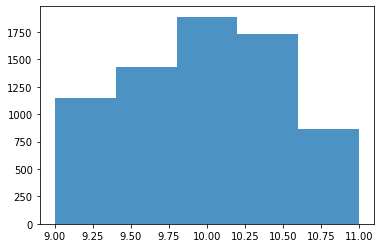

In [20]:
mybins = np.array([ 9.000019,   9.3999768,  9.7999346, 10.1998924, 10.5998502, 10.999808 ])
ssfrflag = (np.log10(nvgood['SFR_hybrid'])- np.log10(nvgood['Mstar'])) > -11
flag = insampleflag & ssfrflag
t = plt.hist(np.log10(nvgood['Mstar'][flag]),color=mycolors[0],alpha=.8,label=f'Ha-12k',bins=mybins)
print((t[0]))
print((t[1]))
print(np.sum(t[0]))        

In [ ]:
os.getcwd()

In [127]:
# how many have masses between 8 and 9?
nmass = (np.log10(nv['Mstar'][insampleflag]) > 8) & (np.log10(nv['Mstar'][insampleflag]) < 9)
print(f"number in sample w/mass 8 < logMstar < 9 = {np.sum(nmass)}")

number in sample w/mass 8 < logMstar < 9 = 1945


In [88]:
# matched the above table using topcat and a 0.5 deg search radius
# save the output table
group = Table.read(homedir+'/research/NED-LVS/NEDLVS_NSF_MRI_primary_0.5degsearch.fits')
group

objname_1,ra_1,dec_1,z_1,GroupID,GroupSize,Separation
,,,,,,arcsec
bytes30,float64,float64,float32,int32,int32,float64
CGCG 408-013,0.66625,8.737,0.018473,--,--,0.0
CGCG 498-067,0.70920833333,31.484888888889998,0.016505,1,4,0.0
CGCG 498-067,0.70920833333,31.484888888889998,0.016505,1,4,1037.2468889137313
UGC 00005,0.7735833333299998,-1.91380555556,0.024253,--,--,0.0
UGC 00011,0.8394583333299998,22.10294444444,0.014894,--,--,0.0
KUG 0000+054,0.84566666667,5.70427777778,0.020641,2,7,0.0
KUG 0000+054,0.84566666667,5.70427777778,0.020641,2,7,1109.3949933282083
UGC 00014,0.89591666667,23.200777777779997,0.024249688,--,--,0.0


In [89]:
groupflag = (group['GroupID'] > 0) 
print("number of primary galaxies in a group field = ",len(group[groupflag]))

number of primary galaxies in a group field =  8867


In [128]:
Ngroups = np.max(group['GroupID'])
print("number of group fields = ",Ngroups)

NameError: name 'group' is not defined

In [93]:
# check which ones are also in the halpha filter
# this is just using the primary targets
groupfilterflag = np.zeros(len(group),'bool')
groupfilterids = np.zeros(len(group))


for i in range(1,Ngroups+1):
    flag = group['GroupID'] == 1
    # pick filter w/the most gals
    zmatch = np.zeros(len(filter_zmin))
    j = 0
    for z1,z2 in zip(filter_zmin,filter_zmax):
        zmatch[j] = np.sum((group['z_1'] > z1) & (group['z_1']<z2))
        j += 1
    # best filter is the one with the most galaxies in it
    if np.max(zmatch) > 1:
        bestfilter = zmatch == np.max(zmatch)
        # now set group flags for the matches to True
        z1 = filter_zmin[bestfilter]
        z2 = filter_zmax[bestfilter]
        flag = (group['z_1'] > z1) & (group['z_1']<z2)
        groupfilterflag[flag]=True
        groupfilterids[flag] = i

In [92]:
print(np.sum(groupfilterflag),len(groupfilterflag))

7922 12067


In [102]:
group = group[groupflag]

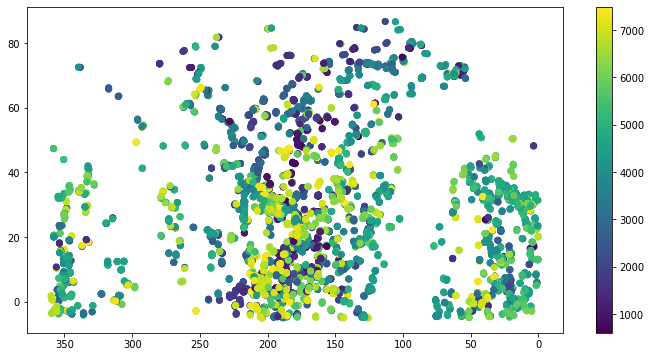

In [122]:
plt.figure(figsize=(12,6))
x = group['ra_1'][groupflag]
y = group['dec_1'][groupflag]
c = group['z_1'][groupflag]*3.e5
plt.scatter(x,y,c=c)
plt.colorbar()
plt.gca().invert_xaxis()

(array([ 789.,  878.,  858.,  861., 1222., 2046., 1785.,  959., 1308.,
        1361.]),
 array([0.002011 , 0.0043098, 0.0066086, 0.0089074, 0.0112062, 0.013505 ,
        0.0158038, 0.0181026, 0.0204014, 0.0227002, 0.024999 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

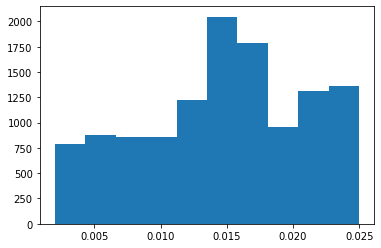

In [120]:
plt.hist(group['z_1'])

# MaNGA

237098


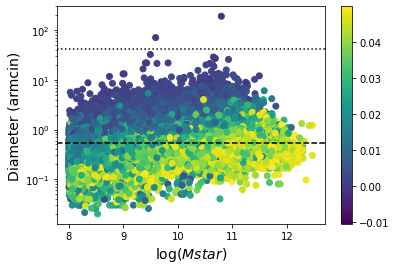

In [23]:
plt.figure()
plotflag = (nvgeom['DIAM'] > 0) & (nv['z'] < .05) & (np.log10(nv['Mstar']) > 8)
print(np.sum(plotflag))
plt.scatter(np.log10(nv['Mstar'][plotflag]),nvgeom['DIAM'][plotflag],c= nv['z'][plotflag])
plt.axhline(32/60,ls='--',c='k',label='MaNGA Fiber Bundle')
plt.axhline(.69*60,ls=':',c='k',label='detector size')
plt.gca().set_yscale('log')
plt.xlabel("$\log(Mstar)$",fontsize=14)
plt.ylabel("Diameter (armcin)",fontsize=14)

plt.colorbar()

In [32]:
manga.colnames

['PLATE',
 'IFUDESIGN',
 'PLATEIFU',
 'MANGAID',
 'DRPALLINDX',
 'MODE',
 'DAPTYPE',
 'DAPDONE',
 'OBJRA',
 'OBJDEC',
 'IFURA',
 'IFUDEC',
 'MNGTARG1',
 'MNGTARG2',
 'MNGTARG3',
 'Z',
 'LDIST_Z',
 'ADIST_Z',
 'NSA_Z',
 'NSA_ZDIST',
 'LDIST_NSA_Z',
 'ADIST_NSA_Z',
 'NSA_ELPETRO_BA',
 'NSA_ELPETRO_PHI',
 'NSA_ELPETRO_TH50_R',
 'NSA_SERSIC_BA',
 'NSA_SERSIC_PHI',
 'NSA_SERSIC_TH50',
 'NSA_SERSIC_N',
 'VERSDRP2',
 'VERSDRP3',
 'VERSCORE',
 'VERSUTIL',
 'VERSDAP',
 'DRP3QUAL',
 'DAPQUAL',
 'RDXQAKEY',
 'BINKEY',
 'SCKEY',
 'ELMKEY',
 'ELFKEY',
 'SIKEY',
 'BINTYPE',
 'BINSNR',
 'TPLKEY',
 'DATEDAP',
 'DAPBINS',
 'RCOV90',
 'SNR_MED',
 'SNR_RING',
 'SB_1RE',
 'BIN_RMAX',
 'BIN_R_N',
 'BIN_R_SNR',
 'STELLAR_Z',
 'STELLAR_VEL_LO',
 'STELLAR_VEL_HI',
 'STELLAR_VEL_LO_CLIP',
 'STELLAR_VEL_HI_CLIP',
 'STELLAR_SIGMA_1RE',
 'STELLAR_RCHI2_1RE',
 'HA_Z',
 'HA_GVEL_LO',
 'HA_GVEL_HI',
 'HA_GVEL_LO_CLIP',
 'HA_GVEL_HI_CLIP',
 'HA_GSIGMA_1RE',
 'HA_GSIGMA_HI',
 'HA_GSIGMA_HI_CLIP',
 'EMLINE_RCHI2_1RE',


In [33]:
import astropy.units as u
from astropy.coordinates import SkyCoord


nedcoords = SkyCoord(nv['ra'],nv['dec'],unit=u.deg, frame='icrs')

mcoords = SkyCoord(manga['OBJRA'],manga['OBJDEC'],unit=u.deg, frame='icrs')


In [5]:

print(f"number in sample = {np.sum(sampleflag)}")

number in sample = 6385


In [34]:
idx, d2d, d3d = nedcoords.match_to_catalog_sky(mcoords)


In [301]:
d2d

NameError: name 'd2d' is not defined

number in manga = 10782
number in manga matched to NEDLVS= 10729


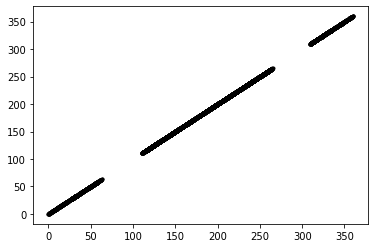

In [79]:
matchflag = d2d < 7/3600.*u.deg # match radius of 15 arcsec
print(f"number in manga = {len(manga)}")
print(f"number in manga matched to NEDLVS= {np.sum(matchflag)}")
# matched catalogs would be
plt.figure()
plt.plot(nv['ra'][matchflag],manga['OBJRA'][idx[matchflag]],'k.')

In [81]:
# print number of mangma with masses between 8 < log Mstar < 8

flag = (np.log10(nv['Mstar'][matchflag]) > 8) & (np.log10(nv['Mstar'][matchflag]) < 9)

print(f"number of manga sources with 8 < logMstar < 9 = {np.sum(flag)}")

number of manga sources with 8 < logMstar < 9 = 275


237098


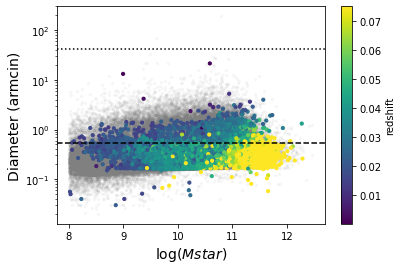

In [53]:
plt.figure()
plotflag = (nvgeom['DIAM'] > 0) & (nv['z'] < .05) & (np.log10(nv['Mstar']) > 8)
plt.scatter(np.log10(nv['Mstar'][plotflag]),nvgeom['DIAM'][plotflag],c='.5',s=5,alpha=.05)
print(np.sum(plotflag))

plotflag = (nvgeom['DIAM'] > 0)  & (np.log10(nv['Mstar']) > 8) & matchflag 
plt.scatter(np.log10(nv['Mstar'][plotflag]),nvgeom['DIAM'][plotflag],c= nv['z'][plotflag],s=10,vmax=.075)
plt.axhline(32/60,ls='--',c='k',label='MaNGA Fiber Bundle')
plt.axhline(.69*60,ls=':',c='k',label='detector size')
plt.gca().set_yscale('log')
plt.xlabel("$\log(Mstar)$",fontsize=14)
plt.ylabel("Diameter (armcin)",fontsize=14)

plt.colorbar(label='redshift')

237098
849


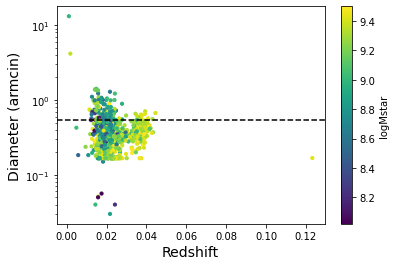

In [74]:
plt.figure()
plotflag = (nvgeom['DIAM'] > 0) & (nv['z'] < .05) & (np.log10(nv['Mstar']) > 8)
#plt.scatter(np.log10(nv['Mstar'][plotflag]),nvgeom['DIAM'][plotflag],c='.5',s=5,alpha=.05)
print(np.sum(plotflag))

plotflag = (nvgeom['DIAM'] > 0)  & (np.log10(nv['Mstar']) > 8) & matchflag & (np.log10(nv['Mstar']) < 9.5)
print(np.sum(plotflag))
plt.scatter(nv['z'][plotflag],nvgeom['DIAM'][plotflag],c= np.log10(nv['Mstar'][plotflag]),s=10)#,vmax=.075)
plt.axhline(32/60,ls='--',c='k',label='MaNGA Fiber Bundle')
#plt.axhline(.69*60,ls=':',c='k',label='detector size')
plt.gca().set_yscale('log')
#plt.xlabel("$\log(Mstar)$",fontsize=14)
plt.ylabel("Diameter (armcin)",fontsize=14)
plt.xlabel("Redshift",fontsize=14)
plt.colorbar(label='logMstar')

4352


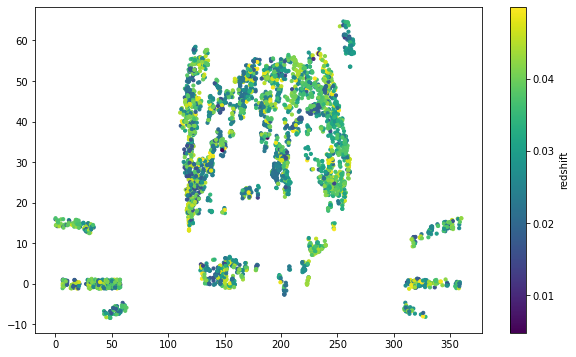

In [59]:
# plot sky coverage of MaNGA sources
plt.figure(figsize=(10,6))
plotflag = (nvgeom['DIAM'] > 0) & (nv['z'] < .05) & (np.log10(nv['Mstar']) > 8) & matchflag & (nvgeom['DIAM'] < .53)
plt.scatter(nv['ra'][plotflag],nv['dec'][plotflag],c= nv['z'][plotflag],s=10)
plt.colorbar(label='redshift')
print(np.sum(plotflag))

4352


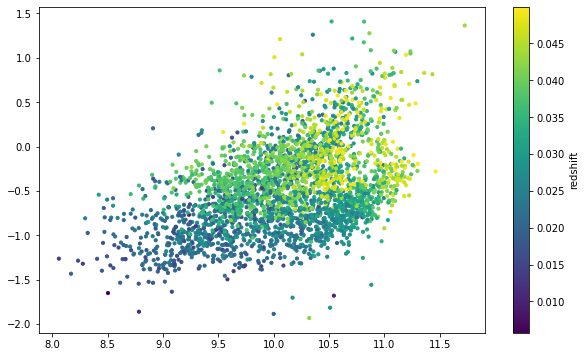

In [58]:
# plot sky coverage of MaNGA sources
plt.figure(figsize=(10,6))
plotflag = (nvgeom['DIAM'] > 0) & (nv['z'] < .05) & (np.log10(nv['Mstar']) > 8) & matchflag & (nvgeom['DIAM'] < .53)
plt.scatter(np.log10(nv['Mstar'][plotflag]),np.log10(nv['SFR_hybrid'][plotflag]),c= nv['z'][plotflag],s=10)
plt.colorbar(label='redshift')
print(np.sum(plotflag))

In [55]:
nv.colnames

['objname',
 'ra',
 'dec',
 'objtype',
 'z',
 'z_unc',
 'z_tech',
 'z_qual',
 'z_qual_flag',
 'z_refcode',
 'ziDist',
 'ziDist_unc',
 'ziDist_method',
 'ziDist_indicator',
 'ziDist_refcode',
 'DistMpc',
 'DistMpc_unc',
 'DistMpc_method',
 'ebv',
 'A_FUV_MWext',
 'A_NUV_MWext',
 'A_J_MWext',
 'A_H_MWext',
 'A_Ks_MWext',
 'A_W1_MWext',
 'A_W2_MWext',
 'A_W3_MWext',
 'A_W4_MWext',
 'm_FUV',
 'm_FUV_unc',
 'm_NUV',
 'm_NUV_unc',
 'Lum_FUV',
 'Lum_FUV_unc',
 'Lum_NUV',
 'Lum_NUV_unc',
 'GALEXphot',
 'm_J',
 'm_J_unc',
 'm_H',
 'm_H_unc',
 'm_Ks',
 'm_Ks_unc',
 'Lum_J',
 'Lum_J_unc',
 'Lum_H',
 'Lum_H_unc',
 'Lum_Ks',
 'Lum_Ks_unc',
 'tMASSphot',
 'm_W1',
 'm_W1_unc',
 'm_W2',
 'm_W2_unc',
 'm_W3',
 'm_W3_unc',
 'm_W4',
 'm_W4_unc',
 'Lum_W1',
 'Lum_W1_unc',
 'Lum_W2',
 'Lum_W2_unc',
 'Lum_W3',
 'Lum_W3_unc',
 'Lum_W4',
 'Lum_W4_unc',
 'WISEphot',
 'SFR_W4',
 'SFR_W4_unc',
 'SFR_hybrid',
 'SFR_hybrid_unc',
 'ET_flag',
 'Mstar',
 'Mstar_unc',
 'MLratio']

In [121]:
.025*3.e5

7500.0

# How to make this proposal more convincing

* maximize overlap with ALFALFA
* 

* match NED-LVS with MaNGA
* then show D25 of MaNGA vs redshift

* spatial sample of MaNGA vs our sample


* size vs stellar mass
  * color code by redshift
  
* plot on a sky plot
  * show manga vs our sample
  
* show SFR-Mstar plot with MaNGA vs our sample
    * which have alfalfa

* cross match MaNGA and NED-LVS
    * use size estimate from NED-LVS
    * how many MaNGA galaxies will fit within IFU
    
    
    
# MaNGA Comparison

* can't get the full range of stellar masses at a single redshift
  * can't sample same large-scale structures
* spatial sampling of MaNGA is not uniform - not good for LSS studies
* MaNGA contains very few galaxies with $logMstar < 9$, which is where we expect to see environmental processing.


* trade b/w sampling inside and outside of Re.  Galaxies with coverage extending to exteriors have little information
w/in Re. (kauffmann+2021) only <400 with adequate data to sample

In [162]:
# manga
R = 2000
dlambda = 

# can get to 2.5 - 3 Re, average half light radius is 3.8 arcsec



SyntaxError: invalid syntax (<ipython-input-162-52dd4d48af09>, line 3)

In [164]:
maxdistance =(.025*3.e5)/70
print(maxdistance)

107.14285714285714


# trying to make a figure comparing MANGA halpha and Virgo

* cross matched proposal sample with manga, then with Virgo catalog
* two matches: VFID1473-NGC3583, and VFID1942-NGC5385

* details on how to access data cubes for a particular galaxy https://www.sdss4.org/dr17/manga/manga-data/data-access/
* tutorial on accessing from python https://www.sdss4.org/dr17/manga/manga-tutorials/how-do-i-look-at-my-data/python
* 16 matches with full virgo sample

In [167]:
topdir = os.getcwd()
print(f"current directory = {topdir}")
os.chdir(homedir+'/research/Virgo/MaNGA')

current directory = /Users/rfinn/github/havirgo/notebooks


In [165]:
vfmanga = Table.read(homedir+'/research/Virgo/MaNGA/vf_v2_main_dapall-v3_1_1-3.1.0.fits')

In [166]:
vfmanga

VFID,RA,DEC,vr,radius,radius_flag,objname,PGC,NSAIDV1,NSAIDV0,AGC,NEDname,HLflag,NSAV1flag,NSAV0flag,A100flag,VFID_V1,COflag,HAflag,HAobsflag,Z0MGSflag,Steerflag,unwiseflag,prefix,PLATE,IFUDESIGN,PLATEIFU,MANGAID,DRPALLINDX,MODE,DAPTYPE,DAPDONE,OBJRA,OBJDEC,IFURA,IFUDEC,MNGTARG1,MNGTARG2,MNGTARG3,Z,LDIST_Z,ADIST_Z,NSA_Z,NSA_ZDIST,LDIST_NSA_Z,ADIST_NSA_Z,NSA_ELPETRO_BA,NSA_ELPETRO_PHI,NSA_ELPETRO_TH50_R,NSA_SERSIC_BA,NSA_SERSIC_PHI,NSA_SERSIC_TH50,NSA_SERSIC_N,VERSDRP2,VERSDRP3,VERSCORE,VERSUTIL,VERSDAP,DRP3QUAL,DAPQUAL,RDXQAKEY,BINKEY,SCKEY,ELMKEY,ELFKEY,SIKEY,BINTYPE,BINSNR,TPLKEY,DATEDAP,DAPBINS,RCOV90,SNR_MED,SNR_RING,SB_1RE,BIN_RMAX,BIN_R_N,BIN_R_SNR,STELLAR_Z,STELLAR_VEL_LO,STELLAR_VEL_HI,STELLAR_VEL_LO_CLIP,STELLAR_VEL_HI_CLIP,STELLAR_SIGMA_1RE,STELLAR_RCHI2_1RE,HA_Z,HA_GVEL_LO,HA_GVEL_HI,HA_GVEL_LO_CLIP,HA_GVEL_HI_CLIP,HA_GSIGMA_1RE,HA_GSIGMA_HI,HA_GSIGMA_HI_CLIP,EMLINE_RCHI2_1RE,EMLINE_SFLUX_CEN,EMLINE_SFLUX_1RE,EMLINE_SFLUX_TOT,EMLINE_SSB_1RE,EMLINE_SSB_PEAK,EMLINE_SEW_1RE,EMLINE_SEW_PEAK,EMLINE_GFLUX_CEN,EMLINE_GFLUX_1RE,EMLINE_GFLUX_TOT,EMLINE_GSB_1RE,EMLINE_GSB_PEAK,EMLINE_GEW_1RE,EMLINE_GEW_PEAK,SPECINDEX_LO,SPECINDEX_HI,SPECINDEX_LO_CLIP,SPECINDEX_HI_CLIP,SPECINDEX_1RE,SFR_1RE,SFR_TOT,Separation
,,,,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
bytes8,float64,float64,float64,float32,bool,bytes28,int32,int32,int32,int64,bytes30,bool,bool,bool,bool,bytes8,bool,bool,bool,bool,bool,bool,bytes36,int64,int64,bytes12,bytes10,int64,bytes4,bytes30,bool,float32,float32,float32,float32,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes8,bytes8,bytes8,bytes8,bytes8,int64,int64,bytes14,bytes14,bytes14,bytes14,bytes14,bytes14,bytes10,float32,bytes15,bytes10,int64,float32,float32[4],float32[4],float32,float32,float32[3],float32[3],float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[35],float32[46],float32[46],float32[46],float32[46],float32[46],float32,float32,float64
VFID0902,233.491551,56.8473569,3240.8,14.161891,True,PGC2549587,2549587,96312,20076,0,WISEA J153357.96+565049.5,True,True,True,False,VFID0903,False,False,False,False,True,True,VFID0902-WISEAJ153357.96+565049.5,8553,3701,8553-3701,1-90984,7134,CUBE,SPX-MILESHC-MASTARSSP,True,233.49152,56.84732,233.49152,56.84732,4240,0,0,0.0108082,32.672543,31.977568,0.0108082,0.0106441,32.672543,31.977568,0.864114,169.826,3.86036,0.822465,171.779,4.53491,2.87173,v3_1_1,v3_1_1,v1_9_1,v5_5_36,3.1.0,0,0,SNRG,SPX,MILESHCMPL11,EMOMMPL11,EFITMPL11SSP,INDXEN,None,-999.0,MILESHC,2020-12-30,746,6.9365506,8.372617 .. 9.321633,31.626291 .. 19.379236,0.39530575,2.4396942,161.0 .. 385.0,18.918644 .. 3.9243076,0.010870917,-26.12507,67.50398,-18.493952,51.410866,46.976654,0.94332653,0.009537538,-403.43475,365.98294,-280.87415,267.03485,287.3545,664.0091,326.8022,0.9717657,-2.360251 .. 7.184607,-9.602706 .. 27.893002,-44.399055 .. 89.54905,-0.059644137 .. 0.17324845,0.5770522 .. 0.75283235,-0.19039437 .. 0.57482815,54.097786 .. 18.505562,0.5951514 .. 4.061541,13.329009 .. 13.041547,38.543194 .. 23.947624,0.085442364 .. 0.08306718,0.6313826 .. 0.7353558,0.56662357 .. 0.21664147,28.616688 .. 19.213425,-0.21627203 .. 0.70182556,0.09365063 .. 1.0831795,-0.17722078 .. 0.7697311,0.070823625 .. 1.0813195,-0.03315832 .. 1.0080444,2.5942274e-05,0.00017193206,0.14776810221585596
VFID1011,228.7539705,55.4320258,3164.0,19.192045,True,2MASXJ15150097+5525555,3386892,139090,28463,0,WISEA J151500.90+552555.3,True,True,True,False,VFID1012,False,False,False,False,True,True,VFID1011-WISEAJ151500.90+552555.3,8589,3704,8589-3704,1-131378,7392,CUBE,SPX-MILESHC-MASTARSSP,True,228.75404,55.43201,228.75404,55.43201,4096,0,0,0

In [242]:
print(f"number of vf halpha and manga = {np.sum(vfmanga['HAobsflag'])}")
print("redshift = ",vfmanga['VFID'][vfmanga['HAobsflag']],vfmanga['vr'][vfmanga['HAobsflag']]/3.e5)

number of vf halpha and manga = 6
redshift =    VFID  
--------
VFID1035
VFID1473
VFID1648
VFID1942
VFID2626
VFID2673           vr         
---------------------
0.0037073333333333333
 0.007035333333333333
 0.007350666666666666
             0.007349
 0.004934666666666667
             0.004864


In [178]:
testgal = vfmanga['VFID'] == 'VFID1942'

plate = vfmanga['PLATE'][testgal][0]
ifudesign = vfmanga['IFUDESIGN'][testgal][0]
print(plate,ifudesign)
rstring = f"wget https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/{plate}/stack/manga-{plate}-{ifudesign}-LOGCUBE.fits.gz ."
print(rstring)
os.system(rstring)

8332 1902
wget https://data.sdss.org/sas/dr17/manga/spectro/redux/v3_1_1/8332/stack/manga-8332-1902-LOGCUBE.fits.gz .


1024

In [220]:
import os     #importing some python modules
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
cube = fits.open(f'manga-{plate}-{ifudesign}-LOGCUBE.fits.gz')    #assumes you are in the same directory as the cube file

# reading in and re-ordering FLUX, IVAR, and MASK arrays from (wavelength, y, x) to (x, y, wavelength).
flux = np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))

wave = cube['WAVE'].data   #reading in wavelength
flux_header = cube['FLUX'].header   #reading in the header of the flux extension

In [180]:
do_not_use = (mask & 2**10) != 0   #finding the bad spaxels
flux_m = np.ma.array(flux, mask=do_not_use)  #new masked flux array

In [264]:
x_center = np.int(flux_header['CRPIX1']) - 1   #finding the middle pixel in x
y_center = np.int(flux_header['CRPIX2']) - 1   #finding the middle pixel in y

redshift = vfmanga['vr'][testgal][0]/3.e5   #redshift of this galaxy

redshift = vfmanga['Z'][testgal][0]   #redshift of this galaxy

print(f"galaxy redshift = {redshift:.3f}")
ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]  #finding the wavelegth range around H$\alpha$
halpha = flux_m[:, :, ind_wave].sum(axis=2)   #summing the fluxes at each spaxel in the wavelength range
im = halpha.T

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]

<ipython-input-264-bc3ee127742f>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_center = np.int(flux_header['CRPIX1']) - 1   #finding the middle pixel in x
<ipython-input-264-bc3ee127742f>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

galaxy redshift = 0.008


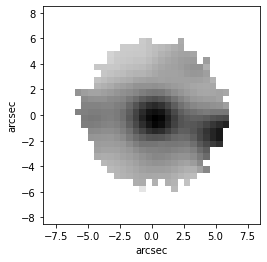

In [278]:
plt.imshow(im, extent=extent, cmap='gray_r')#, vmin=0.1, vmax=100, origin='lower', interpolation='none')
#plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
#plt.gca().invert_xaxis()
plt.show()

In [196]:
mystring = "wget http://199.223.247.130/fits/virgo-download/cutouts-20240805/VFID1942-NGC5383-BOK-20220424-VFID1944/VFID1942-NGC5383-BOK-20220424-VFID1944-CS-gr.fits"
#os.system(mystring)

mystring = "wget http://199.223.247.130/fits/virgo-download/cutouts-20240805/VFID1942-NGC5383-BOK-20220424-VFID1944/VFID1942-NGC5383-BOK-20220424-VFID1944-R-mask.fits"
os.system(mystring)

0

In [221]:
fname = "VFID1942-NGC5383-BOK-20220424-VFID1944-CS-gr.fits"
hdu = fits.open(fname)

mname = "VFID1942-NGC5383-BOK-20220424-VFID1944-R-mask.fits"
mhdu = fits.open(mname)

wcs = WCS(hdu[0].header)

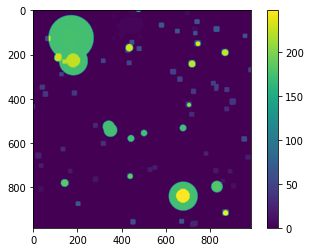

In [199]:
plt.imshow(mhdu[0].data)
plt.colorbar()

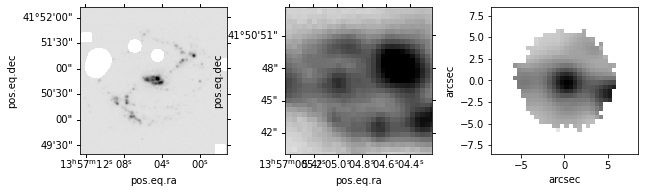

In [267]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
mask = mhdu[0].data > 0
norm = simple_norm(hdu[0].data[~mask], stretch='asinh',max_cut=8,min_cut=-.3)
fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=.4)
ax = plt.subplot(1,3,1,projection=wcs)
maskdat = np.ma.array(hdu[0].data,mask=mask)
plt.imshow(maskdat,cmap='gray_r',norm=norm)
#plt.colorbar()
plt.axis([300,680,300,680])


ax = plt.subplot(1,3,2,projection=wcs)

plt.imshow(maskdat,cmap='gray_r',norm=norm)
hy,hx =  hdu[0].data.shape
hycenter = hy//2
hxcenter = hx//2
dx = 30
dy = 30
plt.axis([hxcenter-dx//2,hxcenter+dx//2,hycenter-dy//2,hycenter+dy//2])


plt.subplot(1,3,3)
plt.imshow(im, extent=extent, cmap='gray_r')#, vmin=0.1, vmax=100, origin='lower', interpolation='none')
#plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
#plt.gca().invert_xaxis()
plt.show()

In [236]:
.002*3.e5

600.0

([], [])

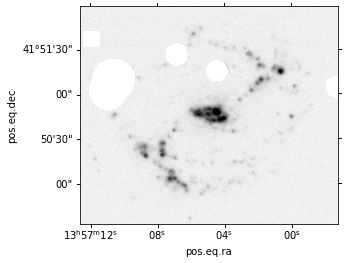

In [277]:
mask = mhdu[0].data > 0
norm = simple_norm(hdu[0].data[~mask], stretch='asinh',max_cut=5,min_cut=-.1)
fig = plt.figure()#figsize=(10,5))
plt.subplots_adjust(wspace=.4)
ax = plt.subplot(1,1,1,projection=wcs)
maskdat = np.ma.array(hdu[0].data,mask=mask)
plt.imshow(maskdat,cmap='gray_r',norm=norm)
#plt.colorbar()
plt.axis([300,680,330,650])
plt.xticks([],[])
plt.yticks([],[])

# Hyper Suprime Cam

In [281]:
w1 = 816 # nm
w2 = 921
w3 = 718
w0 = 656.3

z1 = w1/w0-1
z2 = w2/w0-1
z3 = w3/w0-1
print(z1,z2,z3)

0.24333384123114432 0.4033216516836813 0.09401188480877654


In [282]:
.626*.626*4300

1685.0668

In [283]:
30/10*12

36.0

# SMARTS

* 0.9-m telescope
* 16.8' FOV

In [286]:
xratio = 16.8/37.7
sizeratio = xratio**2

In [287]:
1/sizeratio

5.035749716553289

In [293]:
# approx nights on SRO
numb_nights = 0.5*365*5 # <50% illumination for 5 yrs

# need to observe 5x longer b/c of smaller FOV
numb_nights_smarts = numb_nights/sizeratio

cost_per_night = 500

cost_smarts = numb_nights_smarts*cost_per_night

print(f"running program at SMARTS would cost ${cost_smarts/1.e6:.2f} million")

running program at SMARTS would cost $2.30 million


# Resolution of Images at max redshift of sample

In [24]:
from astropy.cosmology import WMAP9 as cosmo


In [26]:

zmax = 0.025
Mpc_per_radian = cosmo.angular_diameter_distance(zmax)

# assume seeing is 1 arcsec
arcsec_per_radian = 206264
kpc_per_arcsec = Mpc_per_radian.value*1000/arcsec_per_radian
print(f"kpc per arcsec at z={zmax} = {kpc_per_arcsec:.3f}")
#print(f"kpc per arcsec at z={zmax} = {Mpc_per_radian.to('kpc arcsec^-1'):.3f}")
print(Mpc_per_radian)


kpc per arcsec at z=0.025 = 0.509
104.91185003316616 Mpc


# Matching to ALFALFA

In [21]:
Ntot = len(nvgood[insampleflag])
Nmatch_alfalfa = 3244

In [22]:
Nmatch_alfalfa/Ntot

0.27049111981989493

In [ ]:
len